# Ensemble Model Training - Simplified Single-Branch Models

This notebook trains separate simplified CNN models for each feature type and then creates an ensemble.

In [1]:
from datetime import datetime
import os
import json
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.utils import to_categorical, Sequence
from keras.models import Model
from keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from modules.PostgresDBHandler import PostgresDBHandler

2025-07-07 10:23:21.299207: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
# Configuration
dbParams = {
    "dbname": "mydatabase",
    "user": "myuser",
    "password": "mypassword",
    "host": "postgres_server",
    "port": "5432",
}
EPOCHS = 200
BATCH_SIZE = 32
KFOLD_SPLITS = 5
FIXED_LENGTH = 128

# Feature types to train models for
FEATURE_TYPES = [
    'mel_spectrogram', 'mfcc', 'chromagram', 'spectral_contrast',
    'tonnetz', 'constant_q', 'cqt', 'stft', 'harmonic_percussive', 'onset_strength'
]

# Feature shapes for each type
FEATURE_SHAPES = {
    'mel_spectrogram': (64, 128),
    'mfcc': (8, 128),
    'chromagram': (8, 128),
    'spectral_contrast': (3, 128),
    'tonnetz': (6, 128),
    'constant_q': (42, 128),
    'cqt': (84, 128),
    'stft': (512, 128),
    'harmonic_percussive': (1025, 128),
    'onset_strength': (1, 128)
}
# GPU configuration
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Number of available GPUs: {len(gpus)}")
    except RuntimeError as e:
        print(e)

Number of available GPUs: 1


2025-07-07 10:23:22.288928: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-07-07 10:23:22.289585: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-07-07 10:23:22.368838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-07 10:23:22.370545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4080 SUPER computeCapability: 8.9
coreClock: 2.61GHz coreCount: 80 deviceMemorySize: 15.59GiB deviceMemoryBandwidth: 685.51GiB/s
2025-07-07 10:23:22.370554: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-07-07 10:23:22.371580: I tensorflow/stream_executor/platf

In [3]:
# Initialize database connection
db = PostgresDBHandler(**dbParams)
db.connect()

# Get instrument mappings
instruments_mappings = db.get_mappings_instruments()
num_classes = len(instruments_mappings)
print(f"Number of instrument classes: {num_classes}")
print("Instruments:", instruments_mappings['name'].tolist())

db.close()

Number of instrument classes: 9
Instruments: ['oboe', 'sax', 'cello', 'bass', 'clarinet', 'piccolo', 'violin', 'flute', 'trumpet']


In [4]:
class SingleFeatureDataGenerator(Sequence):
    def __init__(self, df, feature_type, label_encoder, batch_size=32, shuffle=True):
        self.df = df.copy()  # Just to be safe
        self.feature_type = feature_type
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.label_encoder = label_encoder

        # Transform labels using the external encoder (DON'T fit again!)
        self.df['instrumentID_encoded'] = self.label_encoder.transform(self.df['instrumentID'])
        self.num_classes = len(self.label_encoder.classes_)
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        batch_df = self.df.iloc[indices]
        
        X = []
        y = []
        
        for _, row in batch_df.iterrows():
            feature_data = np.load(row['featurePath'])
            X.append(feature_data)
            y.append(row['instrumentID_encoded'])
        
        X = np.expand_dims(np.array(X), -1)
        y = to_categorical(y, num_classes=self.num_classes)
        
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def get_labels(self):
        return self.df.iloc[self.indices]['instrumentID_encoded'].values

In [5]:
def create_simple_model(input_shape, num_classes, model_name="simple_cnn"):    
    """Create a simplified single-branch CNN model with reduced capacity."""
    input_layer = Input(shape=(*input_shape, 1), name=f"{model_name}_input")
    
    # Reduced number of filters and layers compared to original
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)    
    x = Flatten()(x)
    
    # Reduced dense layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    
    # Smaller final dense layer
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    output = Dense(num_classes, activation='softmax', name=f"{model_name}_output")(x)
    
    model = Model(inputs=input_layer, outputs=output, name=model_name)
    return model

In [6]:
# Load data for each feature type
db = PostgresDBHandler(**dbParams)
db.connect()

# Get all processed IDs
processed_ids = db.get_all_processed_ids()
print(f"Total processed samples: {len(processed_ids)}")

# Create DataFrames for each feature type
df_dict = {}
for feature_type in FEATURE_TYPES:
    processed_data = db.get_processed_fit_data(processed_ids, feature_type)
    
    if processed_data:
        df = pd.DataFrame(processed_data)
        df_dict[feature_type] = df
        print(f"{feature_type}: {len(df)} samples")
    else:
        print(f"Warning: No data found for {feature_type}")

db.close()

# Filter to only include feature types with data
available_feature_types = list(df_dict.keys())
print(f"\nAvailable feature types: {available_feature_types}")

Total processed samples: 9000
mel_spectrogram: 900 samples
mfcc: 900 samples
chromagram: 900 samples
spectral_contrast: 900 samples
tonnetz: 900 samples
constant_q: 900 samples
cqt: 900 samples
stft: 900 samples
harmonic_percussive: 900 samples
onset_strength: 900 samples

Available feature types: ['mel_spectrogram', 'mfcc', 'chromagram', 'spectral_contrast', 'tonnetz', 'constant_q', 'cqt', 'stft', 'harmonic_percussive', 'onset_strength']


Feature Types:   0%|          | 0/10 [00:00<?, ?it/s]


Training model for mel_spectrogram


mel_spectrogram Folds:   0%|          | 0/5 [00:00<?, ?it/s]


--- Fold 1/5 ---
X shape: (32, 64, 128, 1) y shape: (32, 9)
X min/max: -80.0 1.9073486e-06
y (class distribution in batch): [3. 5. 3. 3. 4. 3. 5. 2. 4.]


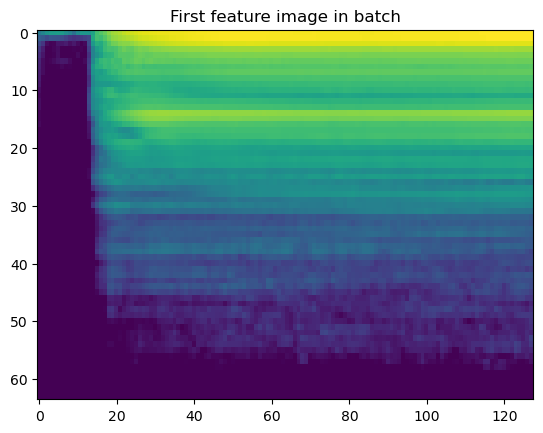

First label (one-hot): [0. 0. 0. 1. 0. 0. 0. 0. 0.]
First label (class index): 3
Label distribution in train_df: instrumentID
4    71
2    71
6    68
5    67
9    66
1    65
3    60
7    56
8    52
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False


2025-07-07 10:24:10.279652: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-07 10:24:10.280188: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-07-07 10:24:10.280355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-07 10:24:10.282771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4080 SUPER computeCapability: 8.9
coreClock: 2.61GHz coreCount: 80 deviceMemorySize: 15.59GiB deviceMemoryBand

Epoch 1/200


2025-07-07 10:27:47.439875: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2025-07-07 10:28:41.537289: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [ ]:
# Training results storage
all_results = {}
all_models = {}

# Fit on the full dataset
global_label_encoder = LabelEncoder()
global_label_encoder.fit(df['instrumentID'])  # Use original labels


# Train individual models for each feature type
for feature_type in tqdm(available_feature_types, desc = "Feature Types"):
    print(f"\n{'='*50}")
    print(f"Training model for {feature_type}")
    print(f"{'='*50}")
    
    df = df_dict[feature_type]
    input_shape = FEATURE_SHAPES[feature_type]
    
    # Initialize results storage for this feature type
    feature_results = {
        'accuracy_list': [],
        'loss_list': [],
        'classification_reports': [],
        'confusion_matrices': [],
        'histories': [],
        'models': []
    }
    
    # Cross-validation
    kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=42)
    
    for fold, (train_idx, test_idx) in enumerate(tqdm(list(kf.split(df)), desc = f"{feature_type} Folds")):
        print(f"\n--- Fold {fold + 1}/{KFOLD_SPLITS} ---")
        
        # Split data
        train_df = df.iloc[train_idx].reset_index(drop=True)
        test_df = df.iloc[test_idx].reset_index(drop=True)
        
        # Further split training data
        train_indices, val_indices = train_test_split(
            np.arange(len(train_df)), test_size=0.2, random_state=42
        )
        
        val_df = train_df.iloc[val_indices].reset_index(drop=True)
        train_df = train_df.iloc[train_indices].reset_index(drop=True)
        
        
        # Create data generators
        train_generator = SingleFeatureDataGenerator(train_df, feature_type, label_encoder=global_label_encoder, shuffle=True)
        val_generator = SingleFeatureDataGenerator(val_df, feature_type, label_encoder=global_label_encoder, shuffle=False)
        test_generator = SingleFeatureDataGenerator(test_df, feature_type, label_encoder=global_label_encoder, shuffle=False)
        
        
        # Create and compile model
        model = create_simple_model(input_shape, num_classes, f"{feature_type}_model")
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )
        
        # Early stopping
        early_stopping = EarlyStopping(
            monitor="val_loss", patience=40, restore_best_weights=True
        )
        
        # Train the model
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=EPOCHS,
            callbacks=[early_stopping],
            verbose=1
        )
        
        feature_results['histories'].append(history.history)
        
        # Evaluate the model
        loss, accuracy = model.evaluate(test_generator, verbose=0)
        feature_results['accuracy_list'].append(accuracy)
        feature_results['loss_list'].append(loss)
        
        print(f"Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")
        
        # Predict and generate reports
        y_pred = model.predict(test_generator, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = test_generator.get_labels()
        
        # Classification report
        report = classification_report(y_true, y_pred_classes, output_dict=True)
        feature_results['classification_reports'].append(report)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_classes).tolist()
        feature_results['confusion_matrices'].append(conf_matrix)
        
        # Save the best model (last one for now)
        feature_results['models'].append(model)
    
    # Store results for this feature type
    all_results[feature_type] = feature_results
    all_models[feature_type] = feature_results['models'][-1]  # Save the last model
    
    # Print summary for this feature type
    mean_acc = np.mean(feature_results['accuracy_list'])
    std_acc = np.std(feature_results['accuracy_list'])
    print(f"\n{feature_type} - Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

Feature Types:  60%
 6/10 [16:15<05:12, 78.15s/it]


==================================================
Training model for mel_spectrogram
==================================================

mel_spectrogram Folds: 100%
 5/5 [13:23<00:00, 73.60s/it]


--- Fold 1/5 ---
X shape: (32, 64, 128, 1) y shape: (32, 9)
X min/max: -80.0 1.9073486e-06
y (class distribution in batch): [3. 5. 3. 3. 4. 3. 5. 2. 4.]

First label (one-hot): [0. 0. 0. 1. 0. 0. 0. 0. 0.]
First label (class index): 3
Label distribution in train_df: instrumentID
4    71
2    71
6    68
5    67
9    66
1    65
3    60
7    56
8    52
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False

2025-07-07 10:24:10.279652: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-07 10:24:10.280188: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-07-07 10:24:10.280355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-07 10:24:10.282771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4080 SUPER computeCapability: 8.9
coreClock: 2.61GHz coreCount: 80 deviceMemorySize: 15.59GiB deviceMemoryBandwidth: 685.51GiB/s
2025-07-07 10:24:10.282784: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-07-07 10:24:10.282803: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2025-07-07 10:24:10.282810: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2025-07-07 10:24:10.282817: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2025-07-07 10:24:10.282823: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2025-07-07 10:24:10.282829: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusolver.so.10
2025-07-07 10:24:10.282836: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusparse.so.10
2025-07-07 10:24:10.282843: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2025-07-07 10:24:10.282890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-07 10:24:10.284198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-07 10:24:10.285824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1862] Adding visible gpu devices: 0
2025-07-07 10:24:10.286038: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-07-07 10:27:47.091515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-07-07 10:27:47.091529: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2025-07-07 10:27:47.091533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2025-07-07 10:27:47.092006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-07 10:27:47.093012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-07 10:27:47.094191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-07 10:27:47.095154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1406] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14010 MB memory) -> physical GPU (device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9)
2025-07-07 10:27:47.153471: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-07-07 10:27:47.154285: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 4199990000 Hz

Epoch 1/200

2025-07-07 10:27:47.439875: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2025-07-07 10:28:41.537289: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7

Accuracy: 0.0944, Loss: 2.1991

--- Fold 2/5 ---
X shape: (32, 64, 128, 1) y shape: (32, 9)
X min/max: -80.0 1.9073486e-06
y (class distribution in batch): [2. 4. 5. 3. 2. 4. 4. 3. 5.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 1. 0. 0.]
First label (class index): 6
Label distribution in train_df: instrumentID
6    69
3    69
1    69
7    66
4    65
2    62
9    62
8    60
5    54
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False


--- Fold 3/5 ---
X shape: (32, 64, 128, 1) y shape: (32, 9)
X min/max: -80.0 3.8146973e-06
y (class distribution in batch): [2. 5. 2. 8. 4. 2. 4. 2. 3.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
First label (class index): 8
Label distribution in train_df: instrumentID
4    72
2    67
9    66
8    65
5    65
1    64
6    63
3    58
7    56
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False

--- Fold 4/5 ---
X shape: (32, 64, 128, 1) y shape: (32, 9)
X min/max: -80.0 1.9073486e-06
y (class distribution in batch): [4. 4. 3. 4. 4. 5. 6. 1. 1.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 1. 0. 0.]
First label (class index): 6
Label distribution in train_df: instrumentID
2    69
7    68
1    66
3    66
8    65
5    62
4    61
6    61
9    58
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False


--- Fold 5/5 ---
X shape: (32, 64, 128, 1) y shape: (32, 9)
X min/max: -80.0 1.9073486e-06
y (class distribution in batch): [3. 4. 5. 3. 3. 6. 2. 3. 3.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 1. 0.]
First label (class index): 7
Label distribution in train_df: instrumentID
6    71
4    71
2    68
3    68
5    64
9    63
1    58
8    57
7    56
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False

mel_spectrogram - Mean Accuracy: 0.0978 ± 0.0120

==================================================
Training model for mfcc
==================================================

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

mfcc Folds: 100%
 5/5 [00:31<00:00,  6.26s/it]


--- Fold 1/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: -609.31323 200.29572
y (class distribution in batch): [4. 5. 4. 1. 9. 1. 2. 3. 3.]

First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 1. 0.]
First label (class index): 7
Label distribution in train_df: instrumentID
4    73
9    69
6    68
2    68
1    65
5    65
3    59
7    56
8    53
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False

--- Fold 2/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: -596.6504 187.85594
y (class distribution in batch): [6. 4. 1. 3. 3. 5. 4. 4. 2.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 1. 0. 0. 0. 0. 0. 0. 0.]
First label (class index): 1
Label distribution in train_df: instrumentID
6    69
1    69
4    67
3    67
7    65
9    65
2    62
8    62
5    50
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False

--- Fold 3/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: -558.8268 189.6047
y (class distribution in batch): [5. 5. 4. 4. 5. 1. 4. 2. 2.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 1. 0. 0. 0. 0. 0.]
First label (class index): 3
Label distribution in train_df: instrumentID
4    74
9    66
2    66
5    65
8    64
1    64
6    63
7    58
3    56
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False


--- Fold 4/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: -560.6386 215.96014
y (class distribution in batch): [4. 4. 1. 2. 4. 4. 7. 5. 1.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 1. 0. 0. 0. 0. 0. 0.]
First label (class index): 2
Label distribution in train_df: instrumentID
2    70
7    66
1    66
5    66
3    66
8    63
6    61
9    59
4    59
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False


--- Fold 5/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: -594.3909 213.05296
y (class distribution in batch): [3. 1. 4. 4. 1. 4. 4. 2. 9.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
First label (class index): 8
Label distribution in train_df: instrumentID
6    71
4    71
2    70
5    66
9    65
3    64
7    58
1    58
8    53
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False

mfcc - Mean Accuracy: 0.0911 ± 0.0147

==================================================
Training model for chromagram
==================================================

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

chromagram Folds: 100%
 5/5 [00:31<00:00,  6.21s/it]


--- Fold 1/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: 0.0 1.0
y (class distribution in batch): [5. 3. 1. 3. 5. 4. 5. 3. 3.]

First label (one-hot): [0. 0. 0. 0. 1. 0. 0. 0. 0.]
First label (class index): 4
Label distribution in train_df: instrumentID
4    73
2    69
6    68
9    66
5    66
1    65
3    59
7    57
8    53
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False


--- Fold 2/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: 0.0 1.0
y (class distribution in batch): [6. 0. 2. 4. 6. 4. 2. 4. 4.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 1. 0. 0. 0.]
First label (class index): 5
Label distribution in train_df: instrumentID
6    69
3    69
1    69
4    66
7    65
2    62
9    62
8    61
5    53
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False

--- Fold 3/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: 8.312639e-06 1.0
y (class distribution in batch): [4. 6. 4. 2. 3. 6. 1. 3. 3.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 1. 0. 0. 0. 0. 0. 0.]
First label (class index): 2
Label distribution in train_df: instrumentID
4    71
2    69
9    66
1    65
5    65
8    64
6    63
3    57
7    56
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False

--- Fold 4/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: 0.0 1.0
y (class distribution in batch): [5. 5. 1. 1. 2. 5. 6. 3. 4.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 1. 0. 0. 0. 0. 0. 0.]
First label (class index): 2
Label distribution in train_df: instrumentID
7    70
2    69
1    65
8    64
3    64
5    64
4    61
6    61
9    58
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False

--- Fold 5/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: 0.0 1.0
y (class distribution in batch): [2. 3. 9. 2. 5. 5. 3. 3. 0.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 1. 0. 0. 0. 0.]
First label (class index): 4
Label distribution in train_df: instrumentID
4    72
6    71
2    69
3    69
5    64
9    63
1    58
8    56
7    54
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False

chromagram - Mean Accuracy: 0.1056 ± 0.0117

==================================================
Training model for spectral_contrast
==================================================

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

spectral_contrast Folds: 100%
 5/5 [00:43<00:00, 10.33s/it]


--- Fold 1/5 ---
X shape: (32, 3, 128, 1) y shape: (32, 9)
X min/max: 0.37260252526396087 56.70268357126612
y (class distribution in batch): [3. 5. 3. 4. 5. 4. 2. 1. 5.]

First label (one-hot): [0. 0. 1. 0. 0. 0. 0. 0. 0.]
First label (class index): 2
Label distribution in train_df: instrumentID
4    73
9    70
2    69
6    68
5    66
1    65
3    58
7    55
8    52
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False

--- Fold 2/5 ---
X shape: (32, 3, 128, 1) y shape: (32, 9)
X min/max: 1.0416550929199389 58.07924881300532
y (class distribution in batch): [8. 1. 5. 2. 2. 3. 4. 4. 3.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
First label (class index): 8
Label distribution in train_df: instrumentID
6    69
1    69
3    68
4    66
9    65
7    64
2    63
8    63
5    49
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False


--- Fold 3/5 ---
X shape: (32, 3, 128, 1) y shape: (32, 9)
X min/max: 1.3602788234469299 57.36006035690242
y (class distribution in batch): [2. 3. 3. 4. 4. 5. 5. 1. 5.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 1. 0. 0.]
First label (class index): 6
Label distribution in train_df: instrumentID
4    72
8    68
2    67
9    65
1    65
6    63
5    62
7    58
3    56
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False


--- Fold 4/5 ---
X shape: (32, 3, 128, 1) y shape: (32, 9)
X min/max: 1.1185629181837378 59.241336919007566
y (class distribution in batch): [4. 7. 3. 3. 2. 4. 4. 2. 3.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
First label (class index): 8
Label distribution in train_df: instrumentID
2    69
8    66
7    66
1    65
3    65
5    64
6    61
9    60
4    60
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False


--- Fold 5/5 ---
X shape: (32, 3, 128, 1) y shape: (32, 9)
X min/max: 1.1437311017300715 58.96714442772701
y (class distribution in batch): [2. 2. 7. 5. 1. 4. 2. 4. 5.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 1. 0. 0. 0.]
First label (class index): 5
Label distribution in train_df: instrumentID
4    72
6    71
2    69
5    67
9    66
3    64
1    58
7    56
8    53
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
spectral_contrast - Mean Accuracy: 0.0978 ± 0.0139

==================================================
Training model for tonnetz
==================================================

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

tonnetz Folds: 100%
 5/5 [00:31<00:00,  6.38s/it]


--- Fold 1/5 ---
X shape: (32, 6, 128, 1) y shape: (32, 9)
X min/max: -0.9690126354224912 0.94446836510906
y (class distribution in batch): [3. 5. 3. 6. 4. 2. 2. 3. 4.]

First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
First label (class index): 8
Label distribution in train_df: instrumentID
4    73
2    69
6    68
9    66
5    66
1    65
3    59
7    57
8    53
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False


--- Fold 2/5 ---
X shape: (32, 6, 128, 1) y shape: (32, 9)
X min/max: -0.8960385653772394 0.9185015190159901
y (class distribution in batch): [3. 7. 2. 3. 1. 1. 4. 5. 6.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 1. 0. 0.]
First label (class index): 6
Label distribution in train_df: instrumentID
3    70
6    69
1    69
4    66
7    64
2    63
9    63
8    63
5    49
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False


--- Fold 3/5 ---
X shape: (32, 6, 128, 1) y shape: (32, 9)
X min/max: -0.9395068660378456 0.938642525463365
y (class distribution in batch): [4. 5. 2. 0. 4. 4. 2. 7. 4.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 1. 0.]
First label (class index): 7
Label distribution in train_df: instrumentID
4    72
8    67
2    67
1    65
9    63
6    63
5    62
7    59
3    58
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False

--- Fold 4/5 ---
X shape: (32, 6, 128, 1) y shape: (32, 9)
X min/max: -0.9523786503705196 0.9082093810417841
y (class distribution in batch): [2. 5. 3. 7. 2. 2. 5. 1. 5.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 1. 0. 0. 0. 0. 0. 0.]
First label (class index): 2
Label distribution in train_df: instrumentID
2    69
7    68
3    66
8    65
1    65
5    64
6    61
4    60
9    58
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False


--- Fold 5/5 ---
X shape: (32, 6, 128, 1) y shape: (32, 9)
X min/max: -0.9187869007000702 0.9420621856115758
y (class distribution in batch): [4. 2. 6. 5. 3. 3. 4. 4. 1.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [1. 0. 0. 0. 0. 0. 0. 0. 0.]
First label (class index): 0
Label distribution in train_df: instrumentID
4    72
6    71
2    69
3    68
5    67
9    62
1    58
7    56
8    53
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False

tonnetz - Mean Accuracy: 0.1000 ± 0.0153

==================================================
Training model for constant_q
==================================================

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

constant_q Folds: 100%
 5/5 [00:32<00:00,  6.53s/it]


--- Fold 1/5 ---
X shape: (32, 42, 128, 1) y shape: (32, 9)
X min/max: -80.0 9.536743e-07
y (class distribution in batch): [2. 6. 3. 2. 3. 3. 4. 3. 6.]

First label (one-hot): [0. 0. 0. 0. 0. 1. 0. 0. 0.]
First label (class index): 5
Label distribution in train_df: instrumentID
4    73
2    69
6    68
9    66
5    65
1    65
3    58
7    57
8    55
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False


--- Fold 2/5 ---
X shape: (32, 42, 128, 1) y shape: (32, 9)
X min/max: -80.0 1.9073486e-06
y (class distribution in batch): [3. 4. 3. 6. 1. 4. 3. 3. 5.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 1. 0. 0.]
First label (class index): 6
Label distribution in train_df: instrumentID
6    69
1    69
3    68
4    66
2    64
7    64
9    63
8    57
5    56
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False

--- Fold 3/5 ---
X shape: (32, 42, 128, 1) y shape: (32, 9)
X min/max: -80.0 4.7683716e-07
y (class distribution in batch): [2. 7. 2. 3. 3. 2. 5. 3. 5.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 1. 0. 0. 0. 0.]
First label (class index): 4
Label distribution in train_df: instrumentID
4    73
2    66
5    65
1    64
9    63
6    63
8    62
7    60
3    60
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
--- Fold 4/5 ---
X shape: (32, 42, 128, 1) y shape: (32, 9)
X min/max: -80.0 1.9073486e-06
y (class distribution in batch): [1. 2. 3. 6. 7. 3. 3. 3. 4.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 1. 0. 0. 0. 0. 0.]
First label (class index): 3
Label distribution in train_df: instrumentID
7    68
3    68
2    68
1    66
8    65
5    63
6    61
4    59
9    58
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False

--- Fold 5/5 ---
X shape: (32, 42, 128, 1) y shape: (32, 9)
X min/max: -80.0 1.9073486e-06
y (class distribution in batch): [3. 2. 2. 5. 3. 2. 4. 7. 4.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 1. 0.]
First label (class index): 7
Label distribution in train_df: instrumentID
4    72
6    71
2    68
5    67
3    65
9    62
1    58
8    57
7    56
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False


constant_q - Mean Accuracy: 0.0844 ± 0.0129

==================================================
Training model for cqt
==================================================

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

cqt Folds:   0%
 0/5 [00:00<?, ?it/s]


--- Fold 1/5 ---
X shape: (32, 84, 128, 1) y shape: (32, 9)
X min/max: -80.0 9.536743e-07
y (class distribution in batch): [4. 4. 1. 1. 3. 5. 3. 4. 7.]

First label (one-hot): [0. 1. 0. 0. 0. 0. 0. 0. 0.]
First label (class index): 1
Label distribution in train_df: instrumentID
4    73
2    69
6    68
9    66
5    65
1    65
3    58
7    57
8    55
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200

---------------------------------------------------------------------------
InvalidArgumentError                      Traceback (most recent call last)
Cell In[8], line 89
     84 early_stopping = EarlyStopping(
     85     monitor="val_loss", patience=40, restore_best_weights=True
     86 )
     88 # Train the model
---> 89 history = model.fit(
     90     train_generator,
     91     validation_data=val_generator,
     92     epochs=EPOCHS,
     93     callbacks=[early_stopping],
     94     verbose=1
     95 )
     97 feature_results['histories'].append(history.history)
     99 # Evaluate the model

File /opt/conda/envs/myenv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1100, in Model.fit(self, x, y, batch_size, epochs, verbose, callbacks, validation_split, validation_data, shuffle, class_weight, sample_weight, initial_epoch, steps_per_epoch, validation_steps, validation_batch_size, validation_freq, max_queue_size, workers, use_multiprocessing)
   1093 with trace.Trace(
   1094     'train',
   1095     epoch_num=epoch,
   1096     step_num=step,
   1097     batch_size=batch_size,
   1098     _r=1):
   1099   callbacks.on_train_batch_begin(step)
-> 1100   tmp_logs = self.train_function(iterator)
   1101   if data_handler.should_sync:
   1102     context.async_wait()

File /opt/conda/envs/myenv/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py:828, in Function.__call__(self, *args, **kwds)
    826 tracing_count = self.experimental_get_tracing_count()
    827 with trace.Trace(self._name) as tm:
--> 828   result = self._call(*args, **kwds)
    829   compiler = "xla" if self._experimental_compile else "nonXla"
    830   new_tracing_count = self.experimental_get_tracing_count()

File /opt/conda/envs/myenv/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py:888, in Function._call(self, *args, **kwds)
    884     pass  # Fall through to cond-based initialization.
    885   else:
    886     # Lifting succeeded, so variables are initialized and we can run the
    887     # stateless function.
--> 888     return self._stateless_fn(*args, **kwds)
    889 else:
    890   _, _, _, filtered_flat_args = \
    891       self._stateful_fn._function_spec.canonicalize_function_inputs(  # pylint: disable=protected-access
    892           *args, **kwds)

File /opt/conda/envs/myenv/lib/python3.9/site-packages/tensorflow/python/eager/function.py:2942, in Function.__call__(self, *args, **kwargs)
   2939 with self._lock:
   2940   (graph_function,
   2941    filtered_flat_args) = self._maybe_define_function(args, kwargs)
-> 2942 return graph_function._call_flat(
   2943     filtered_flat_args, captured_inputs=graph_function.captured_inputs)

File /opt/conda/envs/myenv/lib/python3.9/site-packages/tensorflow/python/eager/function.py:1918, in ConcreteFunction._call_flat(self, args, captured_inputs, cancellation_manager)
   1914 possible_gradient_type = gradients_util.PossibleTapeGradientTypes(args)
   1915 if (possible_gradient_type == gradients_util.POSSIBLE_GRADIENT_TYPES_NONE
   1916     and executing_eagerly):
   1917   # No tape is watching; skip to running the function.
-> 1918   return self._build_call_outputs(self._inference_function.call(
   1919       ctx, args, cancellation_manager=cancellation_manager))
   1920 forward_backward = self._select_forward_and_backward_functions(
   1921     args,
   1922     possible_gradient_type,
   1923     executing_eagerly)
   1924 forward_function, args_with_tangents = forward_backward.forward()

File /opt/conda/envs/myenv/lib/python3.9/site-packages/tensorflow/python/eager/function.py:555, in _EagerDefinedFunction.call(self, ctx, args, cancellation_manager)
    553 with _InterpolateFunctionError(self):
    554   if cancellation_manager is None:
--> 555     outputs = execute.execute(
    556         str(self.signature.name),
    557         num_outputs=self._num_outputs,
    558         inputs=args,
    559         attrs=attrs,
    560         ctx=ctx)
    561   else:
    562     outputs = execute.execute_with_cancellation(
    563         str(self.signature.name),
    564         num_outputs=self._num_outputs,
   (...)
    567         ctx=ctx,
    568         cancellation_manager=cancellation_manager)

File /opt/conda/envs/myenv/lib/python3.9/site-packages/tensorflow/python/eager/execute.py:59, in quick_execute(op_name, num_outputs, inputs, attrs, ctx, name)
     57 try:
     58   ctx.ensure_initialized()
---> 59   tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
     60                                       inputs, attrs, num_outputs)
     61 except core._NotOkStatusException as e:
     62   if name is not None:

InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[64,9] labels_size=[32,9]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at tmp/ipykernel_17869/2933601861.py:89) ]] [Op:__inference_train_function_150543]

Function call stack:
train_function


In [ ]:
# Create ensemble predictions
print("\n" + "="*50)
print("Creating Ensemble Predictions")
print("="*50)

# Use the last fold of each feature type for ensemble evaluation
ensemble_results = {
    'accuracy_list': [],
    'loss_list': [],
    'classification_reports': [],
    'confusion_matrices': []
}

# For simplicity, we'll use the last fold of each feature type
for fold in tqdm(range(KFOLD_SPLITS), desc = "Ensemble Folds", Leave = True):
    print(f"\n--- Ensemble Fold {fold + 1}/{KFOLD_SPLITS} ---")
    
    # Get predictions from all models for this fold
    all_predictions = {}
    
    for feature_type in available_feature_types:
        if feature_type in all_results:
            # Get the model from this fold
            model = all_results[feature_type]['models'][fold]
            
            # Get test data for this fold (we need to recreate it)
            df = df_dict[feature_type]
            kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=42)
            train_idx, test_idx = list(kf.split(df))[fold]
            test_df = df.iloc[test_idx].reset_index(drop=True)
            
            test_generator = SingleFeatureDataGenerator(test_df, feature_type, batch_size=BATCH_SIZE, shuffle=False)
            
            # Get predictions
            pred = model.predict(test_generator, verbose=0)
            all_predictions[feature_type] = pred
            
            # Store true labels (should be the same for all feature types)
            if 'y_true' not in locals():
                y_true = test_generator.get_labels()
    
    # Simple averaging ensemble
    if all_predictions:
        ensemble_pred = np.mean(list(all_predictions.values()), axis=0)
        ensemble_pred_classes = np.argmax(ensemble_pred, axis=1)
        
        # Calculate ensemble accuracy
        ensemble_accuracy = accuracy_score(y_true, ensemble_pred_classes)
        ensemble_results['accuracy_list'].append(ensemble_accuracy)
        
        print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
        
        # Classification report
        report = classification_report(y_true, ensemble_pred_classes, output_dict=True)
        ensemble_results['classification_reports'].append(report)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, ensemble_pred_classes).tolist()
        ensemble_results['confusion_matrices'].append(conf_matrix)

# Store ensemble results
all_results['ensemble'] = ensemble_results

In [ ]:
# Save results and models
try:
    os.mkdir("ensemble_models")
except FileExistsError:
    print("Folder already exists")
except Exception:
    print("Unknown error")

# Create version folder
date_part = datetime.now().date().__str__().replace('-', '_')
last_version = os.listdir(path="ensemble_models") if os.path.exists("ensemble_models") else []
last_version = [name.rpartition("_v")[-1] for name in last_version if date_part in name]
if len(last_version):
    last_version = int(sorted(last_version)[-1])
else:
    last_version = 0
folder_name = f"{date_part}_v{last_version+1}"

os.makedirs(os.path.join("ensemble_models", folder_name), exist_ok=True)

# Save individual models
for feature_type, model in all_models.items():
    model_path = os.path.join("ensemble_models", folder_name, f"{feature_type}_model.h5")
    model.save(model_path)
    print(f"Saved {feature_type} model to {model_path}")

# Save results
results_data = {
    'individual_results': {ft: {k: v for k, v in res.items() if k != 'models'} 
                          for ft, res in all_results.items() if ft != 'ensemble'},
    'ensemble_results': all_results['ensemble'],
    'feature_types': available_feature_types,
    'num_classes': num_classes,
    'feature_shapes': FEATURE_SHAPES,
    'training_config': {
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'kfold_splits': KFOLD_SPLITS,
        'fixed_length': FIXED_LENGTH
    },
    'instrument_mappings': instruments_mappings.to_dict()
}

results_path = os.path.join("ensemble_models", folder_name, "results.json")
with open(results_path, 'w') as f:
    json.dump(results_data, f, indent=2, default=str)

print(f"\nResults saved to: {results_path}")
print(f"Models saved to: ensemble_models/{folder_name}/")

In [ ]:
# Print summary of results
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)

print("\nIndividual Model Performance:")
for feature_type in available_feature_types:
    if feature_type in all_results:
        accuracies = all_results[feature_type]['accuracy_list']
        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        print(f"  {feature_type}: {mean_acc:.4f} ± {std_acc:.4f}")

print("\nEnsemble Performance:")
if 'ensemble' in all_results:
    ensemble_accuracies = all_results['ensemble']['accuracy_list']
    ensemble_mean = np.mean(ensemble_accuracies)
    ensemble_std = np.std(ensemble_accuracies)
    print(f"  Ensemble: {ensemble_mean:.4f} ± {ensemble_std:.4f}")

# Find best individual model
best_individual = max(
    [(ft, np.mean(all_results[ft]['accuracy_list'])) 
     for ft in available_feature_types if ft in all_results],
    key=lambda x: x[1]
)

improvement = ensemble_mean - best_individual[1]
print(f"\nBest Individual Model: {best_individual[0]} ({best_individual[1]:.4f})")
print(f"Ensemble Improvement: {improvement:.4f} ({improvement*100:.2f}%)")